

```
# Importing necessary libraries
```



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
np.random.seed(42)

In [2]:
# Define the K-means function as initialization for the EM algorithm, since it's sensitive to the initial values

def kmeans(data, k, results, max_iterations=1000):
  # Randomly initialize centroids
  centroids = data[np.random.choice(range(data.shape[0]), k, replace=False)]

  results["KMeans_init"] = {"\mu": centroids, "K": k, "max_iterations": max_iterations}

  for _ in range(max_iterations):

    # Assign each data point to the nearest centroid
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Update centroids
    new_centroids = [np.array(data[labels == i].mean(axis=0)) for i in range(k)]

    # Check for convergence
    if np.all(centroids[0] == new_centroids[0]):
      break
    centroids = new_centroids

  return labels, centroids, results

In [3]:
#Defining the Estimation step
def expectation_step(pi, X, mu, Sigma, N, K):
  # Initialize the responsibilities matrix
  gamma = np.zeros((N, K))

  # Calculate the probability density values for each data point and component
  pdf_values = np.array([multivariate_normal.pdf(X, mu[k], Sigma[k]) for k in range(K)]).T

  # Calculate the denominator and numerator for updating the responsibilities
  denominator = np.dot(pi, pdf_values.T)
  numerator = np.multiply(pi, pdf_values)

  # Update the responsibilities
  gamma = numerator / denominator[:, np.newaxis]

  return gamma

In [4]:
#Defining the Max step
def maximization_step(K, gamma, N, X, mu, Sigma, pi, sigma_min):
  new_mu = mu.copy()
  new_Sigma = Sigma.copy()
  new_pi = pi.copy()

  for k in range(K):
    # Compute the effective number of data points assigned to each component
    N_k = gamma[:, k].sum()

    # Update the mean for each component
    new_mu[k] = (1 / N_k) * np.dot(gamma[:, k], X)

    # Update the covariance matrix for each component
    new_Sigma[k] = (1 / N_k) * np.dot(gamma[:, k] * (X - new_mu[k]).T, X - new_mu[k])

    # Add the regularization term:
    new_Sigma[k] += sigma_min

    # Update the mixing coefficients
    new_pi = gamma.sum(axis=0) / N
  return new_mu, new_Sigma, new_pi

In [5]:
def log_likelihood_fn(X, mu, Sigma, pi, K):
  # Compute the probability density values for each data point and component
  pdf_values = np.array([multivariate_normal.pdf(X, mu[k], Sigma[k]) for k in range(K)]).T

  # Compute the weighted sum of the probability density values
  weighted_pdf = np.dot(pi, pdf_values.T)

  # Compute the log-likelihood of the data
  log_likelihood = np.sum(np.log(weighted_pdf))
  return log_likelihood

In [6]:
def em_algorithm(X=np.load("data/clustering_dataset.npy"), K=3, epsilon=0.1, sigma_min=1e-6,n_iter_kmeans=100):
  # initialize the values
  N = X.shape[0]
  D = X.shape[1]

  # Create dictionary to track data:
  results = {}

  # Run k-means clustering
  labels, initial_mean, results = kmeans(X, K, results, n_iter_kmeans)
  squared_euclids = [np.linalg.norm(X[labels == label, :] - initial_mean[label], ord=2)**2/(labels ==label).sum() \
                     for label in set(labels)]

  initial_covariance = [squared_euclids[i] * np.eye(D) for i in range(K)]
  #visualize the Clusters from KMeans
  plt.scatter(X[:, 0], X[:, 1], c=labels)
  plt.title("Clusters produced by KMeans")
  plt.show()
  # initialize parameters
  initial_weights = [1/K for _ in range(K)]
  # fill with the results of knn
  results["em_init"] = {"\mu": initial_mean, "\Sigma": initial_covariance, "\pi": initial_weights, "k":
  K,\
  "\epsilon": epsilon, "\sigma_min": sigma_min,
  "log likelihood": log_likelihood_fn(X, initial_mean, initial_covariance,
  initial_weights, K)}

  i = 0
  log_likelihood = None # Initialize log_likelihood
  while True:
    i += 1
    # do the harlem shake
    gamma = expectation_step(initial_weights, X, initial_mean, initial_covariance, N, K)
    initial_mean, initial_covariance, initial_weights = maximization_step(K, gamma, N, X, initial_mean
    , initial_covariance, initial_weights,
    sigma_min)
    new_log_likelihood = log_likelihood_fn(X, initial_mean, initial_covariance, initial_weights, K)
    if log_likelihood is not None and abs(new_log_likelihood - log_likelihood) < epsilon:
      break # Stop the loop if the difference is smaller than epsilon
    log_likelihood = new_log_likelihood

  results["em_final"] = {"\mu": initial_mean, "\Sigma": initial_covariance, "\pi": initial_weights, "k":
  K,\
  "\epsilon": epsilon, "\sigma_min": sigma_min,
  "log likelihood": log_likelihood_fn(X, initial_mean, initial_covariance,
  initial_weights, K)}
  #visualize the Clusters from KMeans
  plt.scatter(X[:, 0], X[:, 1], c=gamma.argmax(axis=1))
  # Visualize the Gaussian Mixture Model
  x, y = np.mgrid[0:15:.05, -13:10:.05]
  pos = np.empty(x.shape + (2,))
  pos[:, :, 0] = x
  pos[:, :, 1] = y
  for k in range(K):
    rv = multivariate_normal(mean=initial_mean[k], cov=initial_covariance[k])
    plt.contour(x, y, rv.pdf(pos))
    plt.title(f"GMM after {i} iterations")
  return results

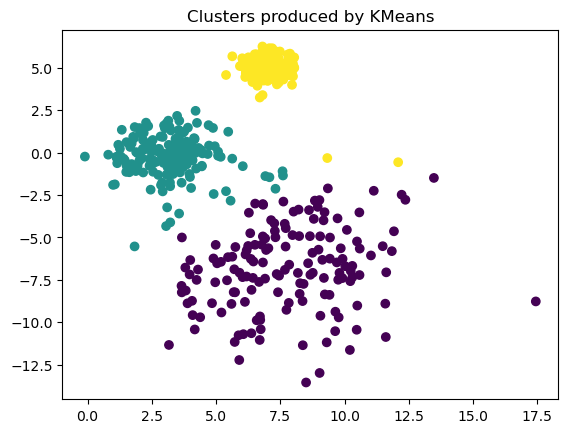

None
None


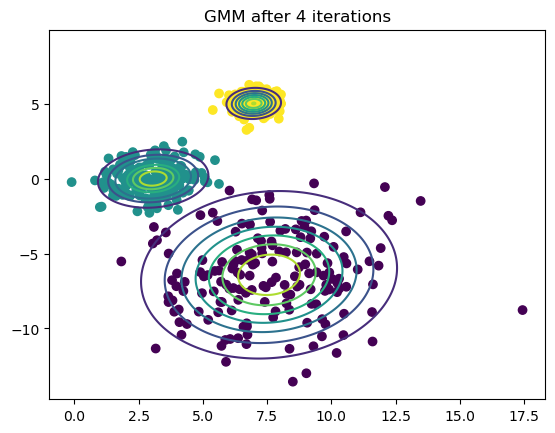

In [7]:
#Print the resutl
results = em_algorithm()
pd.set_option('display.max_colwidth', None)
knn_init = pd.Series(results["KMeans_init"])
print(knn_init.to_latex("./knn.tex"))
em_dict = {k: v for k, v in results.items() if k.startswith('em')}
em = pd.DataFrame(em_dict).T
print(em.to_latex("./em.tex"))